In [44]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2

plt.style.use("ggplot")

In [45]:
img = cv2.imread("../data/download_image_monthly/20171024/full/7ea5ecd63f7fa6627a6ba95559f5e288bbe45d40.jpg")
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

(-0.5, 564.5, 799.5, -0.5)

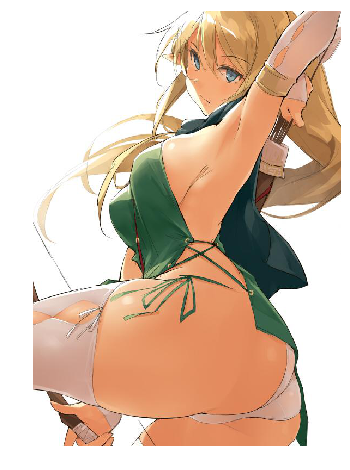

In [46]:
plt.figure(figsize=(12,8))
plt.imshow(img_rgb)
plt.axis("off")

In [59]:
img[799]

array([[255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       ..., 
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255]], dtype=uint8)

RGBそれぞれについてcountをするために、画像を崩して前処理

SOMをつかって似た色をまとめた画像を作っていく

### 自己組織化マップ

In [5]:
class SOM():

    def __init__(self, teachers, N, seed=None):
        self.teachers = np.array(teachers).reshape(-1,3)
        self.n_teacher = self.teachers.shape[0]
        self.N = N
        if not seed is None:
            np.random.seed(seed)

        x, y = np.meshgrid(range(self.N), range(self.N))
        self.c = np.hstack((y.flatten()[:, np.newaxis],
                            x.flatten()[:, np.newaxis]))
        self.nodes = np.random.rand(self.N*self.N,
                                    self.teachers.shape[1])

    def train(self):
        for i, teacher in enumerate(self.teachers):
            bmu = self._best_matching_unit(teacher)
            d = np.linalg.norm(self.c - bmu, axis=1)
            L = self._learning_ratio(i)
            S = self._learning_radius(i, d)
            self.nodes += L * S[:, np.newaxis] * (teacher - self.nodes)
        return self.nodes

    def _best_matching_unit(self, teacher):
        #compute all norms (square)
        norms = np.linalg.norm(self.nodes - teacher, axis=1)
        bmu = np.argmin(norms) #argment with minimum element 
        return np.unravel_index(bmu,(self.N, self.N))

    def _neighbourhood(self, t):#neighbourhood radious
        halflife = float(self.n_teacher/4) #for testing
        initial  = float(self.N/2)
        return initial*np.exp(-t/halflife)

    def _learning_ratio(self, t):
        halflife = float(self.n_teacher/4) #for testing
        initial  = 0.1
        return initial*np.exp(-t/halflife)

    def _learning_radius(self, t, d):
        # d is distance from BMU
        s = self._neighbourhood(t)
        return np.exp(-d**2/(2*s**2))

### SOMに通す前の前処理
+ 画像サイズを大きすぎないようにリサイズ
+ 自己組織化マップ用に画像の数値を正規化

In [6]:
# リサイズ
n = 2
img_rgb = cv2.resize(img_rgb, (img.shape[1]//n, img.shape[0]//n))
# 正規化
img_rgb_norm = img_rgb / np.linalg.norm(img_rgb) * 255

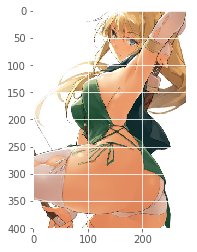

In [7]:
plt.imshow(img_rgb)

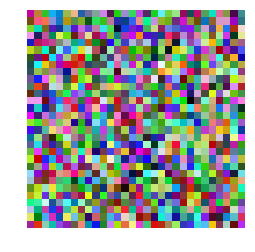

array([[ 0.52252688,  0.31000583,  0.21446689],
       [ 0.51772958,  0.31248821,  0.2145792 ],
       [ 0.51472316,  0.31506121,  0.21541855],
       ..., 
       [ 0.57289964,  0.57317276,  0.57318793],
       [ 0.57327638,  0.57327653,  0.57327667],
       [ 0.57327679,  0.57327679,  0.57327679]])

In [8]:
n = 30
som = SOM(np.random.permutation(img_rgb_norm), N=n,  seed=10)

# Initial map
plt.imshow(som.nodes.reshape(n,n,3),
           interpolation='none')
plt.axis("off")
plt.show()

# Train
som.train()

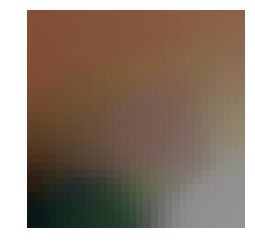

In [9]:
# Trained MAP
plt.imshow(som.nodes.reshape(n,n,3),
           interpolation='none')
plt.axis("off")
plt.show()

## K-means法を使って画像をクラスタリング

In [173]:
df1 = pd.DataFrame(img_rgb_norm.reshape(-1,3))

In [174]:
df1.head()

,0,1,2
0,0.573277,0.573277,0.573277
1,0.573277,0.573277,0.573277
2,0.573277,0.573277,0.573277
3,0.573277,0.573277,0.573277
4,0.573277,0.573277,0.573277


色素数が多いのでもう少し小さくまとめる

In [171]:
from sklearn.cluster import KMeans

In [175]:
rgb_array = img_rgb_norm.reshape(-1,3)

### K-meansの最適なクラスタ数について
また最適なクラスタ数についてはエルボー法(クラスタごとの誤差平方和をプロット)する。

> https://qiita.com/deaikei/items/11a10fde5bb47a2cf2c2

In [238]:
MAX_CLST = 10
dist = []
for i in range(1, MAX_CLST+1):
    predict = KMeans(n_clusters=i,
                    init="k-means++",
                    n_init=MAX_CLST,
                    max_iter=300,
                    random_state=98)
    predict.fit(rgb_array)
    dist.append(predict.inertia_)

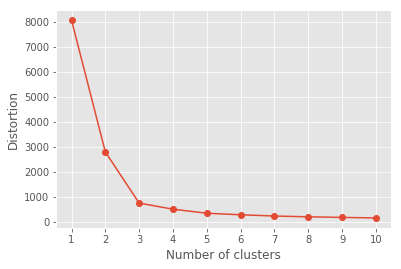

In [239]:
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.plot(range(1,MAX_CLST+1),dist[:],marker='o')

clusterの誤差平方和で急激に誤差が減っているところをクラスタ数としてクラスタリングする

In [240]:
dist = np.array(dist)

In [243]:
dist

array([ 8060.73584859,  2794.21068854,   751.61804263,   509.00363719,
         347.49786436,   285.65211344,   235.06387932,   204.55012332,
         179.81650499,   160.06113651])

In [245]:
# クラスタが減らなくなった位置を探る
diff = dist[:-1] - dist[1:]

In [249]:
def k_optimize(dist):
    for i, param in enumerate(dist[1:]):
        if param > diff[i]:
            return i+1

In [253]:
k = k_optimize(dist)
predict = KMeans(n_clusters=k)
df1["cluster_id"] = predict.fit_predict(rgb_array)

In [257]:
color_list = []
for i in range(k):
    rgb_mean = df1[df1["cluster_id"] == i].mean()
    color_list.append(rgb_mean[0:3])

<Container object of 3 artists>

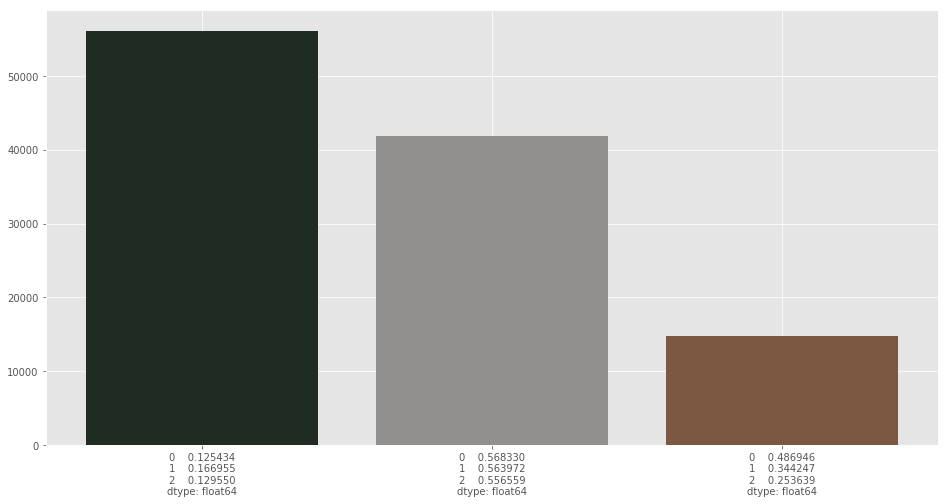

In [258]:
x = np.arange(1,k+1)
plt.figure(figsize=(16,8))
plt.bar(x, df1["cluster_id"].value_counts(), color=color_list, tick_label=color_list, align="center")

In [6]:
import numpy as np
import pandas as pdx

In [17]:
df = pd.read_csv("../data/cluster_rgb.csv", index_col = 0)

In [18]:
df

,2149fc4d,22347650,3d035224,48e2c628,721788da,793a83ad,7ea5ecd6,955a168f,a18a966a,b65a8036,...,5b3da03d,71e6ee11,77bced4b,8745df98,90e7d5ef,92a8fa1b,b29d5125,b5108a38,e5bb5d0c,fb616c3d
0,0.386237,0.369918,0.123725,0.076994,0.041073,0.241868,0.486946,0.069295,0.212804,0.420451,...,0.329123,0.232735,0.128960,0.115382,0.119028,0.436443,0.292595,0.201711,0.226440,0.175749
1,0.419821,0.347968,0.090253,0.045075,0.037706,0.218265,0.344247,0.063351,0.217924,0.381301,...,0.323815,0.222600,0.097852,0.062426,0.121906,0.383437,0.279766,0.114768,0.203711,0.116288
2,0.392099,0.350247,0.081565,0.049821,0.038708,0.220568,0.253639,0.074362,0.216242,0.382300,...,0.319306,0.228421,0.129713,0.054230,0.094530,0.336881,0.273975,0.183264,0.207044,0.171131
3,0.193851,0.181467,0.278562,0.270991,0.147956,0.053615,0.568330,0.301631,0.074171,0.172217,...,0.152025,0.122077,0.294726,0.346191,0.278396,0.225858,0.077479,0.522357,0.144937,0.401163
4,0.164013,0.140897,0.259323,0.248408,0.129698,0.039739,0.563972,0.300868,0.101494,0.126864,...,0.116963,0.078487,0.281176,0.234181,0.278942,0.153987,0.067643,0.506756,0.105600,0.341950
5,0.110035,0.156089,0.259732,0.240749,0.115696,0.053202,0.556559,0.300562,0.125106,0.149023,...,0.118079,0.088461,0.307653,0.213250,0.247247,0.168875,0.072277,0.508626,0.112308,0.370321
6,NaN,NaN,NaN,NaN,NaN,0.088742,0.125434,0.237841,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.420121,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,0.119658,0.166955,0.222875,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.291493,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,0.210986,0.129550,0.218079,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.335250,NaN,NaN
